In [1]:
import csv
import os

%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import datetime as dt

char_set={'q','w','e','r','t','y','u','i','o','p','a','s','d','f','g','h','j','k','l','z','x','c','v','b','n','m',\
#         'Q','W','E','R','T','Y','U','I','O','P','A','S','D','F','G','H','J','K','L','Z','X','C','V','B','N','M',\
          '<bcksp>','spc','<lshft>'}
input_case=['all']
log_buffer=dt.timedelta(seconds=1)

log_data,lh_accel,lh_gyro,lh_gravity,rh_accel,rh_gyro,rh_gravity=dp.preprocess_data(char_set,input_case,log_buffer)
# print shapes
print "log_data shape:",log_data.shape
print "lh_accel shape:",lh_accel.shape
print "lh_gyro shape:",lh_gyro.shape
print "lh_gravity shape:",lh_gravity.shape
print "rh_accel shape:",rh_accel.shape
print "rh_gyro shape:",rh_gyro.shape
print "rh_gravity shape:",rh_gravity.shape

total number of files in  library : 8
Successfully completed 1 files
Successfully completed 2 files
Successfully completed 3 files
Successfully completed 4 files
Successfully completed 5 files
Successfully completed 6 files
Successfully completed 7 files
Successfully completed 8 files
total number of files in  room : 9
total number of files in  room2 : 4
Successfully completed 1 files
Successfully completed 2 files
Successfully completed 3 files
Successfully completed 4 files
total number of files in  room3 : 3
Successfully completed 1 files
Successfully completed 2 files
total number of files in  room4 : 8
Successfully completed 1 files
Successfully completed 2 files
total number of files in  room5 : 7
Successfully completed 1 files
Successfully completed 2 files
total number of files in  room6 : 3
Successfully completed 1 files
Successfully completed 2 files
Successfully completed 3 files
total number of files in  room7 : 2
Successfully completed 1 files
log_data shape: (22178, 3)
lh

IOError: cannot write mode RGBA as JPEG

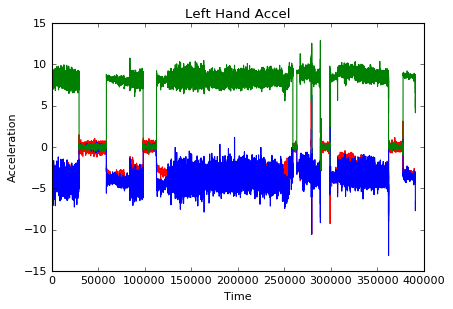

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
num_samples=rh_accel.shape[0]
plt.plot(range(num_samples),rh_accel[:,1],'r-',range(num_samples),rh_accel[:,2],'b-',range(num_samples),rh_accel[:,3],'g-')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Left Hand Accel')
plt.savefig('accel_data.jpg')
plt.show()

In [13]:
import numpy as np
import process_data_type_speed as pdts
import pickle
window_time=dt.timedelta(seconds=4)
buffer=dt.timedelta(microseconds=800000)
data_sampling='continuous'
Xtr, ytr, Xva, yva, Xte, yte, char_to_indx, indx_to_char=\
        pdts.process_data_for_rnn(log_data,lh_accel,lh_gyro,lh_gravity,rh_accel,rh_gyro,rh_gravity,\
        char_set,0.09,0,data_sampling=data_sampling,window_time=window_time,buffer=buffer)

# print data shape
print "Xtr shape:",Xtr.shape
print "ytr shape:",ytr.shape
print "Xva shape:",Xva.shape
print "yva shape:",yva.shape
print "Xte shape:",Xte.shape
print "yte shape:",yte.shape
print "len(char_to_indx):",len(char_to_indx)
print "len(indx_to_char):",len(indx_to_char)

('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('Completed iteration ', 74600, '/', 305709)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('Completed iteration ', 104000, '/', 305709)
('Completed iteration ', 104200, '/', 305709)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('Completed iteration ', 157600, '/', 305709)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog instance', 0)
('omitting num keylog ins

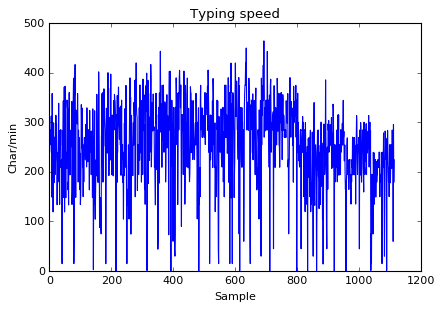

In [14]:
plt.plot(ytr)
plt.xlabel('Sample')
plt.ylabel('Char/min')
plt.title('Typing speed')
plt.show()

In [15]:
data=dict()
data['Xtr']=Xtr
data['ytr']=ytr
data['Xva']=Xva
data['yva']=yva
data['Xte']=Xte
data['yte']=yte
data['word_to_idx']=char_to_indx
data['idx_to_word']=indx_to_char
pickle.dump(data, open("../Data/pickle/"+
                       str(window_time.seconds)+"s_"+data_sampling+".p", "wb" ) )
print "Dumped pickle data"

Dumped pickle data


In [11]:
import torch
import numpy as np
import trainer
import datetime
from scipy.io import loadmat
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from net import Net


# OPTIONS
DEBUG = False
CONTINUE_TRAINING = False
MODEL_PATH = 'output/25epoch_gce_model.pth'  # .pth file for existing model if continuing training
OPTIMIZER_PATH = 'optimizer.pth'  # .pth file for existing optimizer if continuing training
EPOCHS = 50
BATCH_SIZE = 50
LR = 1e-5
REG = 1e-5
FILE_PATH = "../Data/pickle/4s_continuous.p"
SAVE_DIR = "../Data/output"
CHECKPOINT_INTERVAL = 10  # number of epochs between checkpoints (save model and loss curve)
NUM_TEST_SAMPLES = 20  # for generating test samples at the end


# GENERATE SAVE DIRECTORY PATH
timestamp = '{:%Y%m%d_%H%M%S}'.format(datetime.datetime.now())  # for save_dir
if not os.path.exists('../Data/output'):
    os.makedirs('../Data/output')
save_dir = '../Data/output/' + timestamp + '_' + str(EPOCHS) + 'epochs_' + str(REG) + 'reg'
if DEBUG:
    save_dir += '_debug'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# TRAIN AND SAVE MODEL AND OPTIMIZER
if CONTINUE_TRAINING:
    model = FCN()
    model.load_state_dict(torch.load(MODEL_PATH))

    if os.path.exists(OPTIMIZER_PATH):
        optimizer = torch.optim.Adam(model.parameters())
        optimizer.load_state_dict(torch.load(OPTIMIZER_PATH))
    else:
        optimizer = None

    model, optimizer, losses, dlo = trainer.train(save_dir, model=model, optimizer=optimizer,
                                       epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, reg=REG,
                                       checkpoint_interval=CHECKPOINT_INTERVAL, debug=DEBUG)
else:
    model, optimizer, losses, dlo = trainer.train(save_dir=save_dir, epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, lr=LR, reg=REG, file_path=FILE_PATH,
                    checkpoint_interval=CHECKPOINT_INTERVAL)
torch.save(model.state_dict(), save_dir+'/final_model.pth')  # only saves parameters
torch.save(optimizer.state_dict(), save_dir+'/final_optimizer.pth')
# load them back using:
# model = FCN()
# model.load_state_dict(torch.load('model.pth'))
# optimizer = torch.optim.Adam()
# optimizer.load_state_dict(torch.load('optimizer.pth'))


# LOSS CURVE
plt.plot(np.arange(losses.shape[0]) + 1, losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig(save_dir+'/final_loss_curve.png')
plt.close()


# TEST THE MODEL
test_preds, test_acc = trainer.test(model, dlo)
print('Final test accuracy: {0:.3f}%'.format(test_acc * 100))

test_set_size=dlo.get_test_set_size()
plt.plot(range(test_set_size), test_preds, 'r-', range(test_set_size), dlo.test_labels, 'b-')
plt.xlabel('Samples')
plt.ylabel('Char/min')
plt.tight_layout()
plt.savefig(save_dir+'/pred_vs_gt.png')
plt.close()

Epoch: 000    Iter: 0000    Loss: 81006.6328125
Epoch: 000    Iter: 0001    Loss: 73399.6171875
Epoch: 000    Iter: 0002    Loss: 74334.90625
Epoch: 000    Iter: 0003    Loss: 76035.71875
Epoch: 000    Iter: 0004    Loss: 62924.8554688
Epoch: 000    Iter: 0005    Loss: 68125.1796875
Epoch: 000    Iter: 0006    Loss: 71038.4765625
Epoch: 000    Iter: 0007    Loss: 67493.6953125
Epoch: 000    Iter: 0008    Loss: 67843.65625
Epoch: 000    Iter: 0009    Loss: 78755.40625
Epoch: 000    Iter: 0010    Loss: 72641.0859375
Epoch: 000    Iter: 0011    Loss: 74745.9765625
Epoch: 000    Iter: 0012    Loss: 74678.203125
Epoch: 000    Iter: 0013    Loss: 72362.2734375
Epoch: 000    Iter: 0014    Loss: 73489.78125
Epoch: 000    Iter: 0015    Loss: 73416.1484375
Epoch: 000    Iter: 0016    Loss: 71487.0703125
Epoch: 000    Iter: 0017    Loss: 78325.390625
Epoch: 000    Iter: 0018    Loss: 75715.21875
Epoch: 000    Iter: 0019    Loss: 65341.171875
Epoch: 001    Iter: 0000    Loss: 76824.046875
Epoch: 0